In [1]:
# Data Wrangling
import pandas as pd
import numpy as np

# Multi-criteria decision analysis (MCDA)
from skcriteria.madm import simple, similarity
from skcriteria import DecisionMatrix, mkdm
from skcriteria.preprocessing import invert_objectives, scalers
from skcriteria.pipeline import mkpipe

Just creating some toy data here for an example. Imagine each ID is an individual model. Then A-E are your metrics. These could be anything we wanted but for the sake of simplicity I have just created some random positive integers and some random negative floats. But these really could take any value. 

In [2]:
df = pd.DataFrame(np.random.randint(1,100,size=(5, 4)), columns=list('ABCD'), index=['ID1', 'ID2', 'ID3', 'ID4', 'ID5'])
E  = np.random.uniform(-.00004, -.5, 5)
df['E'] = E.tolist()
df

,A,B,C,D,E
ID1,51,30,6,31,-0.324685
ID2,45,61,90,51,-0.394994
ID3,66,30,62,66,-0.054201
ID4,77,83,44,59,-0.226453
ID5,7,98,65,51,-0.493122


The next thing you have to do is create a **Decision Matrix** object. Here you have to specify what your objective is in relation to minimization or maximization relative to the A-E inputs. So, for example, lets say the first measure 'A' is logloss, we want to minimize that, and 'B' is the predicted throughput of applicants and that we wish to maximize, we simply specify this in a list as follows ['min', 'max', etc.]. Finally we also would include the associated weights for A-E. So following the above example if 'A' -- our logloss -- is not as important then we would weight this as .5, and then predicted growth is of greater importance we would then weight this as 2, again we put these in the form of a list as follows [.5, 2, etc.]. You will notice the in the **Decision Matrix** object the direction (min or max in the form of arrows) and the associated weighting regime attached to each of the A-E inputs. 

In [3]:
criteria_data = DecisionMatrix(df, 
                         [min, max, min, max, min], # Min or Max, minimize, e.g., logloss; maximize, profit KPI 
                         [.5,2,1,1,.5]) # Weights
criteria_data

A[▼ 0.5] B[▲ 2.0] C[▼ 1.0] D[▲ 1.0]  E[▼ 0.5]
ID1       51       30        6       31 -0.324685
ID2       45       61       90       51 -0.394994
ID3       66       30       62       66 -0.054201
ID4       77       83       44       59 -0.226453
ID5        7       98       65       51 -0.493122
[5 Alternatives x 5 Criteria]

<AxesSubplot:xlabel='Criteria', ylabel='Alternatives'>

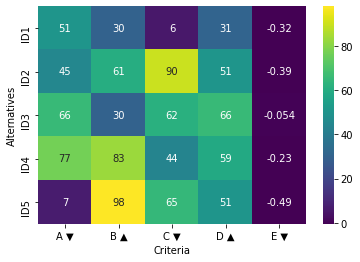

In [4]:
criteria_data.plot()

Quick to just give you some insight we then pass the ```MinimizeToMaximize()``` function to the **DecisionMatrix** object b/c otherwise we will simply not be able to optimize. So you will see after this step we now have changed the direction of the arrows to up as we are going to try and maximize these values. There are other approaches that could be adopted here, but for the sake of simplicty this should help you follow the logic. 

In [5]:
inverter = invert_objectives.MinimizeToMaximize()
dmt = inverter.transform(criteria_data)
dmt

A[▲ 0.5] B[▲ 2.0]  C[▲ 1.0] D[▲ 1.0]   E[▲ 0.5]
ID1  0.019608       30  0.166667       31  -3.079910
ID2  0.022222       61  0.011111       51  -2.531684
ID3  0.015152       30  0.016129       66 -18.449843
ID4  0.012987       83  0.022727       59  -4.415927
ID5  0.142857       98  0.015385       51  -2.027895
[5 Alternatives x 5 Criteria]

Likewise we need to transform our data and so we will scale here. Like the above, there are other approaches beyond ```SumScaler()``` that can be adopted but for simplicity I use this. You will see that the values for all inputs have now been scaled.

In [6]:
scaler = scalers.SumScaler(target="both")
dmt = scaler.transform(dmt)
dmt

A[▲ 0.1]  B[▲ 0.4]  C[▲ 0.2]  D[▲ 0.2]  E[▲ 0.1]
ID1  0.092131  0.099338  0.718333  0.120155  0.100963
ID2  0.104415  0.201987  0.047889  0.197674  0.082992
ID3  0.071192  0.099338  0.069516  0.255814  0.604809
ID4  0.061022  0.274834  0.097954  0.228682  0.144760
ID5  0.671240  0.324503  0.066308  0.197674  0.066477
[5 Alternatives x 5 Criteria]

The above two steps I did to show you what happens within what is better achieved by simply creating a pipe. Much like ```scikit-learn```, ```scikit-criteria``` has a useful wrapper that enables you to pass the above two steps into a pipe along with the algo/solver. Here I just use ```TOPSIS``` which leverages euclidean distance. This is again just an example. There are some other very elegant solutions for these kinds of multi-criteria decision optimisation problems in the ```scikit-criteria``` package that I really like. There is one potential limitation I should note here, and I have not fully explored the source code, but it appears that the ```DecisionMatrix()``` object cannot have more than 20 inputs. You will get an error in such instances. I plan to raise and issue with the ```scikit-criteria``` developers around this and possibly dig into the source code to see if I might be able to simply remedy the issue. 

In [7]:
pipe_topsis = mkpipe(
    invert_objectives.MinimizeToMaximize(),
    scalers.VectorScaler(target="matrix"), 
    scalers.SumScaler(target="weights"),
    similarity.TOPSIS(),
)
pipe_topsis

SKCPipeline(steps=[('minimizetomaximize', MinimizeToMaximize()), ('vectorscaler', VectorScaler(target='matrix')), ('sumscaler', SumScaler(target='weights')), ('topsis', TOPSIS())])

Above you will see you now have a nice pipeline object that you can simply pass to the decision matrix.

In [8]:
dec = pipe_topsis.evaluate(criteria_data)
dec

,ID1,ID2,ID3,ID4,ID5
Rank,2,4,5,3,1


Above you see the results of the optimisation and the associated method that was leveraged. 

In [9]:
type(dec)

skcriteria.core.data.RankResult

Above you can see that this is a special type of object that the scikit-criteria team created. The issue here is that when you have literally hundreds of models or whatever you are trying to optimize get this strange wide essentially useless object that does not play well with ```Pandas``` or ```Numpy``` so below is the most elegant solution I managed to come up with that could return a useable ```pd.DataFrame()``` with the associated rank attached.

In [10]:
df.loc[:,'rank_topsis'] = dec.rank_
df.sort_values(by='rank_topsis', ascending=True)

,A,B,C,D,E,rank_topsis
ID5,7,98,65,51,-0.493122,1
ID1,51,30,6,31,-0.324685,2
ID4,77,83,44,59,-0.226453,3
ID2,45,61,90,51,-0.394994,4
ID3,66,30,62,66,-0.054201,5
